In [92]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
#sys.path.append('/n/des/lee.5922/programs/cosmolike/MG_musigma/')
from noshellavg_v2 import *
from mock_test import *
#from run_error_analysis import *
#from plot_chain import plot_single, plot_triple, plot_distributions, plot_summary_bar
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize Class, Calculate datavector and cov matrices

No Shotnoise, No Finger of God term

In [94]:
"""
 b = galaxy bias
 f = structure growth rate
 s = velocity dispersion in FoG term 
 nn = shot noise 
"""
cosmo = class_covariance(KMIN=0.001, KMAX = 10, n=3000, RMIN = 0.001, RMAX = 180, n2 = 181, \
                         b = 2.0, f = 0.74, s=0.0, nn=3.0e-04, rscale = 'lin', kscale='lin')

#cosmo.compile_fortran_modules()

# copy class to keep initial setting
cosmo2 = cosmo
cosmo2.MatterPower()

# calling matter power spectrum from camb
cosmo.MatterPower()
p_model = cosmo.multipole_P(0)
xi_model = cosmo.multipole_Xi(0)

# calculate covariance matrix
covp_model = cosmo.covariance_PP(0,0)     # cov P monopole
covxi_model = cosmo.covariance_Xi(0,0)    # cov Xi monopole  : double bessel FT of covp_model
covpxi_model = cosmo.covariance_PXi(0,0)  # cov Pxi monopole : FT of covp_model
covtot_model = np.vstack(( np.hstack((covp_model, covpxi_model )), \
                          np.hstack((covpxi_model.T, covxi_model )) ))   # cov_combined
dpdb,_,_ = cosmo.derivative_P_bfs(0)      # dp/db
dxdb,_,_ = cosmo.derivative_bfs(0)        # dxi/db

## Generate Mocks

In [58]:
header = "class_covariance(KMIN=0.001, KMAX = 10, n=3000, RMIN = 0.001, RMAX = 180, n2 = 181, \
                         b = 2.0, f = 0.74, s=0.0, nn=3.0e-04, rscale = 'lin', kscale='lin')"
dirs = '../data_txt/mocks10/'
p_mock, xi_mock = generate_mocks( cosmo, p_model, covp_model, N_mock = 500 )
#save_mocks( cosmo, p_mock, xi_mock, header = header, dir = dirs  )
kcenter, p_mock, rcenter, xi_mock = load_mocks(dir = dirs)
mocks = np.hstack(( p_mock, xi_mock ))

generate mocks... size= 500
3333.33333333


Mock Covariance matrices

In [59]:
mock_covpxi = mock_covariance(p_model, xi_model, p_mock, xi_mock)
mock_covp = mock_covariance(p_model, p_model, p_mock, p_mock)
mock_covxi = mock_covariance(xi_model, xi_model, xi_mock, xi_mock)
mock_covtot = np.vstack(( np.hstack((mock_covp, mock_covpxi )), np.hstack((mock_covpxi.T, mock_covxi )) ))

### Theory Datavector with varying bias

#### 2D Interpolation 

In [60]:
datavp_interp, datavxi_interp = datavector_bias_2d_interp(cosmo)
cosmo.b = 2.0 

Calculate datavector p(b) and xi(b) for b = [0.5,3.5]
generate 2D interpolation table 


In [61]:
# interpolate
bbin = np.linspace(0.5, 3.5, 20000)
datav_p = datavp_interp(cosmo.kbin, bbin)
datav_xi = datavxi_interp(cosmo.rcenter, bbin)
datav_com = np.hstack((datav_p, datav_xi))

#### Mock, Theory data vectors

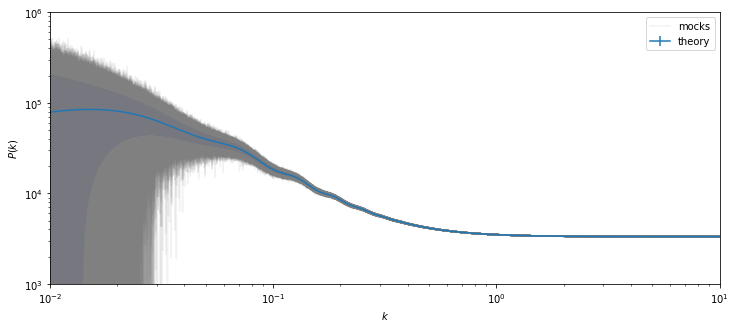

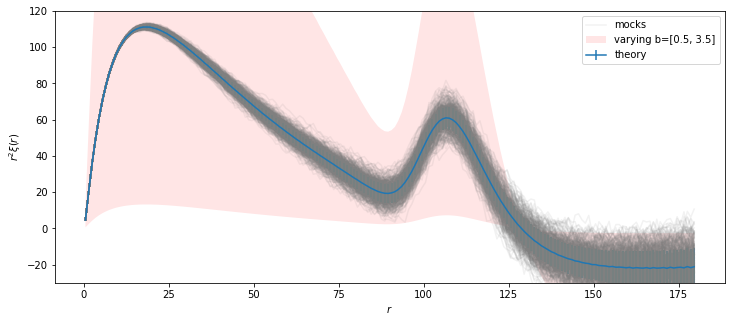

In [62]:
kcenter = cosmo.kbin
fig, ax = plt.subplots(figsize = (12,5))
#for i in range(100): 

for i in range(len(p_mock)) : ax.plot(kcenter, p_mock[i],  color='grey', alpha = 0.1)
ax.plot(kcenter, p_mock[-1], color='grey', alpha = 0.1, label = 'mocks')

ax.errorbar(kcenter, p_model, \
            yerr = np.sqrt(covp_model.diagonal()), fmt='', label = 'theory')

ax.fill_between(cosmo.kbin, datav_p[0], datav_p[-1], color = 'red', alpha = 0.1, label = 'varying b =[0.5,3.5]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-02, 10)
ax.set_ylim(1e03, 1e06)
ax.legend(loc='best')
ax.set_ylabel(r'$P(k)$')
ax.set_xlabel(r'$k$')

fig, ax = plt.subplots(figsize = (12,5))
#for i in range(10): 
for i in range(len(xi_mock)) : ax.plot(cosmo.rcenter, cosmo.rcenter**2*xi_mock[i], color='grey', alpha = 0.1)
ax.plot(cosmo.rcenter, cosmo.rcenter**2*xi_mock[-1], color='grey', alpha = 0.1, label = 'mocks')
ax.errorbar(cosmo.rcenter, cosmo.rcenter**2*xi_model, \
            yerr = cosmo.rcenter**2*np.sqrt(covxi_model.diagonal()), fmt='',label = 'theory')
ax.fill_between(cosmo.rcenter, cosmo.rcenter**2* datav_xi[0], 
                cosmo.rcenter**2* datav_xi[-1], facecolor = 'red', alpha = 0.1, label = 'varying b=[0.5, 3.5]')
ax.set_ylim(-30, 120)
ax.set_ylabel(r'$r^2 \xi(r)$')
ax.set_xlabel(r'$r$')
ax.legend(loc='best')

#### Mock cov, Theoretical Cov

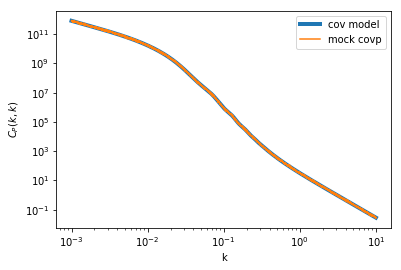

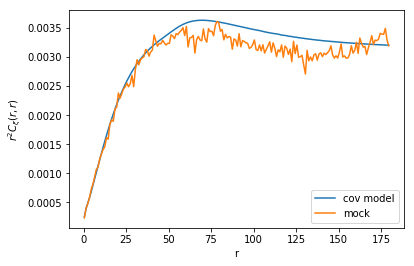

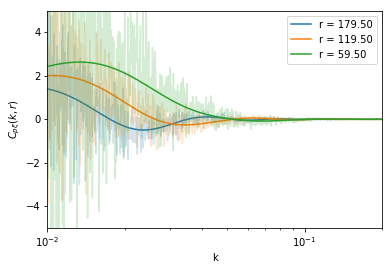

In [97]:
fig, ax = plt.subplots()

kcenter = cosmo.kbin
ax.loglog(kcenter, covp_model.diagonal(), '-', linewidth = 4.0, label = 'cov model')
ax.loglog(kcenter, mock_covp.diagonal(), '-', label ='mock covp')
ax.set_xlabel('k')
ax.set_ylabel(r'$C_P (k,k)$')
ax.legend()

fig, ax = plt.subplots()
ax.plot(cosmo.rcenter, cosmo.rcenter**2*covxi_model.diagonal(), label='cov model')
ax.plot(cosmo.rcenter, cosmo.rcenter**2*mock_covxi.diagonal(), '-', label = 'mock')
#ax.plot(cosmo.rcenter, cosmo.rcenter**2*cov_xi_3.diagonal(), '-', label = 'model2')
ax.set_xlabel('r')
ax.set_ylabel(r'$r^2 C_{\xi}(r,r)$')
ax.legend()

fig, ax = plt.subplots()
for i in np.arange(0, cosmo.rcenter.size, 60):
    ax.plot(cosmo.kbin, mock_covpxi[:,i], alpha = 0.2)
    ax.plot(cosmo.kbin, covpxi_model[:,i], label='r = {:0.2f}'.format(cosmo.rcenter[i]), color = ax.lines[-1].get_color())
    
ax.set_ylim(-5, 5)
ax.set_xlim(1e-02,0.2)
ax.set_xlabel('k')
ax.set_ylabel(r'$C_{p\xi}(k,r)$')
ax.set_xscale('log')
ax.legend(loc='best')

## Calcuate Bestfit Bias 

Setting k range and r range

In [65]:
kmin = 0.04
kmax = 0.12
rmin = 20
rmax = 180

#### Theoretical calculation 

In [66]:
sigma_p = getting_sigma_bs_theory( cosmo2, b = bbin, cov = covp_model, datavs = datav_p, 
                                     mockdatavs = p_mock, p=True, kmin=kmin, kmax=kmax )
sigma_x = getting_sigma_bs_theory( cosmo2, b = bbin, cov = covxi_model, datavs = datav_xi, 
                                     mockdatavs = xi_mock, rmin = rmin, rmax=rmax )
sigma_d = getting_sigma_bs_diff_theory( cosmo2, b = bbin, covp = covp_model, covxi = covxi_model, 
                          datavsp = datav_p, datavsxi = datav_xi, 
                          mockdatavsp = p_mock, mockdatavsxi = xi_mock, kmin=kmin, kmax=kmax, rmin=rmin, rmax=rmax )
sigma_c = getting_sigma_bs_com_theory( cosmo2, b = bbin, cov = covtot_model, 
                                     datavs = datav_com, mockdatavs = mocks,
                                    kmin = kmin, kmax = kmax, rmin=rmin, rmax=rmax)

# print out results-------------------------------
print '---------------------------------\
\n Error on bias (Theory) \n sigma_p      : {} \n sigma_xi     : {} \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_p, sigma_x, sigma_c, sigma_d)

Nk  359  kmin 1201  kmax 1559
 theory : 0.00514835031190225
Nr  160  rmin 159  rmax 0
 theory : 0.008930434905889979
Nk  359  kmin 1201  kmax 1559
Nr  160  rmin 159  rmax 0
 theory : 0.004460253224724413
N  519  kmin 1201  kmax 1559  rmin 159  rmax 0
 theory : 0.002778718548165727
---------------------------------
 Error on bias (Theory) 
 sigma_p      : 0.0051483503119 
 sigma_xi     : 0.00893043490589 
 sigma_combin : 0.00277871854817 
 sigma_diff   : 0.00446025322472 
---------------------------------


#### Mock : Perform chisquare calculation to obtain bestfit biases with Cp, Cxi, Ctot, Cdiff

Nk  359  kmin 1201  kmax 1559
Nr  160  rmin 159  rmax 0
 sigma_b : 0.005752174668646907
 theory : 0.004460253224724413
N  519  kmin 1201  kmax 1559  rmin 159  rmax 0
 sigma_b : 0.0026804123102712736
 theory : 0.002778718548165727


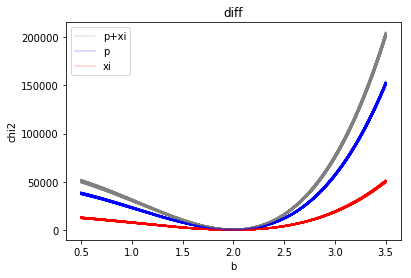

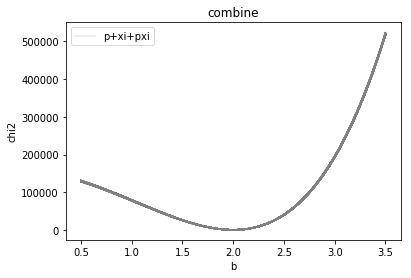

In [68]:

#bestfit_b_p, chi2p = getting_sigma_bs( cosmo2, b = bbin, cov = covp_model, datavs = datav_p, 
#                                     mockdatavs = p_mock, p=True, kmin=kmin, kmax=kmax )
#bestfit_b_xi, chi2x = getting_sigma_bs( cosmo2, b = bbin, cov = covxi_model, datavs = datav_xi, 
#                                     mockdatavs = xi_mock, rmin = rmin, rmax=rmax )
bestfit_b_diff ,chi2_diff = getting_sigma_bs_diff( cosmo2, b = bbin, covp = covp_model, covxi = covxi_model, 
                          datavsp = datav_p, datavsxi = datav_xi, 
                          mockdatavsp = p_mock, mockdatavsxi = xi_mock, kmin=kmin, kmax=kmax, rmin=rmin, rmax=rmax )
bestfit_b_com, chi2_com = getting_sigma_bs_com( cosmo2, b = bbin, cov = covtot_model, 
                                     datavs = datav_com, mockdatavs = mocks,
                                    kmin = kmin, kmax = kmax, rmin=rmin, rmax=rmax)

In [69]:
# print out results-------------------------------
sigma_pm, sigma_xm, sigma_cm, sigma_dm \
= np.std(bestfit_b_p), np.std(bestfit_b_xi), np.std(bestfit_b_com), np.std(bestfit_b_diff)
print '---------------------------------\
\n Error on bias (Mock) \n sigma_p      : {} \n sigma_xi     : {} \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_pm, sigma_xm, sigma_cm, sigma_dm)

---------------------------------
 Error on bias (Mock) 
 sigma_p      : 0.00510695034135 
 sigma_xi     : 0.00925139186075 
 sigma_combin : 0.00268041231027 
 sigma_diff   : 0.00575217466865 
---------------------------------


#### Uncorrelated P and Xi mocks

In [77]:
xi_mock2 = np.vstack((xi_mock[1:,], xi_mock[0,:]))

Nk  359  kmin 1201  kmax 1559
Nr  160  rmin 159  rmax 0
 sigma_b : 0.0045379237514215
 theory : 0.004460253224724413
N  519  kmin 1201  kmax 1559  rmin 159  rmax 0
 sigma_b : 0.0746601996857519
 theory : 0.002778718548165727


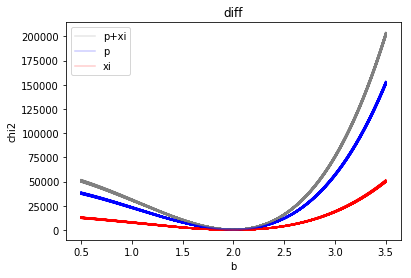

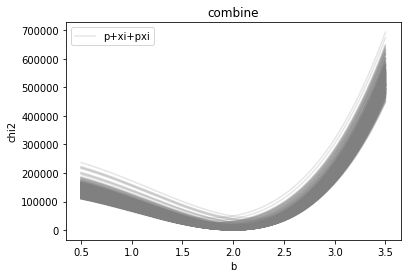

In [82]:
mocks2 = np.hstack((p_mock, xi_mock2))
bestfit_b_diff2 = getting_sigma_bs_diff( cosmo2, b = bbin, covp = covp_model, covxi = covxi_model, 
                          datavsp = datav_p, datavsxi = datav_xi, 
                          mockdatavsp = p_mock, mockdatavsxi = xi_mock2, kmin=kmin, kmax=kmax, rmin=rmin, rmax=rmax )
bestfit_b_com2 = getting_sigma_bs_com( cosmo2, b = bbin, cov = covtot_model, 
                                     datavs = datav_com, mockdatavs = mocks2,
                                    kmin = kmin, kmax = kmax, rmin=rmin, rmax=rmax)

In [99]:
# print out results-------------------------------
sigma_cm2, sigma_dm2 = np.std(bestfit_b_com2[0]), np.std(bestfit_b_diff2[0])
print '---------------------------------\
\n Error on bias (Uncorrelated Mock) \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_cm2, sigma_dm2)

---------------------------------
 Error on bias (Uncorrelated Mock) 
 sigma_combin : 0.0746601996858 
 sigma_diff   : 0.00453792375142 
---------------------------------


#### Obtain cross bias from bestfit b_p and b_xi

In [79]:
combine_sigmab(bestfit_b_p, bestfit_b_xi)

cov matrix = 
 |0.0000260809   0.0000350167| 
 |0.0000350167   0.0000855883|

sigma_p       : 0.005106950341346256
sigma_xi      : 0.00925139186075077
sigma_combin  : 0.004915606208267038
sigma_diff    : 0.004470972746189203


#### Check outliers 


bestfit b exists between b=[1.98849616539, 2.00850283428]
bestfit b exists between b=[1.98249416472, 2.01550516839]



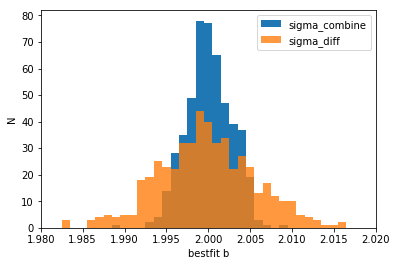

In [80]:
bhist_bin = np.linspace(0.5, 3.5, 3000)
fig, ax = plt.subplots()
Nb, _, _ = ax.hist( bestfit_b_com, bins = bhist_bin, label = 'sigma_combine' )
Nb2, _, _ = ax.hist( bestfit_b_diff, bins = bhist_bin, label = 'sigma_diff', alpha = 0.8 )
ax.set_xlabel('bestfit b')
ax.set_ylabel('N');
ax.set_xlim(1.98, 2.02)
ax.legend()

nonzero = bhist_bin[:-1][ Nb > 0.0]
nonzero2= bhist_bin[:-1][ Nb2 > 0.0]
print '\nbestfit b exists between b=[{}, {}]'.format(nonzero.min(), nonzero.max() )
print 'bestfit b exists between b=[{}, {}]\n'.format(nonzero2.min(), nonzero2.max() )

#### Chi2 distribution test

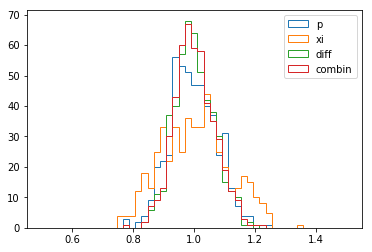

In [81]:
chibin = np.linspace(0.5, 1.5, 50)
fig, ax = plt.subplots()
#ax.plot( np.arange(len(chi2p) ), chi2p)
ax.hist(chi2p, bins = chibin, label='p', histtype='step');
ax.hist(chi2x, bins = chibin, label ='xi', histtype='step');
ax.hist(chi2_diff, bins = chibin, label='diff', histtype='step');
ax.hist(chi2_com, bins = chibin, label='combin', histtype='step');
ax.legend()

In [101]:
print '* with SHOT Noise'

# print out results-------------------------------
print '---------------------------------\
\n#1 Error on bias (Theory) \n sigma_p      : {} \n sigma_xi     : {} \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_p, sigma_x, sigma_c, sigma_d)

# print out results-------------------------------
sigma_pm, sigma_xm, sigma_cm, sigma_dm \
= np.std(bestfit_b_p), np.std(bestfit_b_xi), np.std(bestfit_b_com), np.std(bestfit_b_diff)
print '---------------------------------\
\n#2 Error on bias (Mock) \n sigma_p      : {} \n sigma_xi     : {} \n sigma_combin : {} \n sigma_diff   : {} \
\n'.format(sigma_pm, sigma_xm, sigma_cm, sigma_dm)

# print out results-------------------------------
sigma_cm2, sigma_dm2 = np.std(bestfit_b_com2[0]), np.std(bestfit_b_diff2[0])
print ' (Uncorrelated Mock) \n sigma_combin : {} \n sigma_diff   : {} \
\n---------------------------------'.format(sigma_cm2, sigma_dm2)

print '---------------------------------\n\
#3 Error on bias \n \
(Mock, cross bias is obtained \n from bestfit bias of P and Xi)\n'
combine_sigmab(bestfit_b_p, bestfit_b_xi)

* with SHOT Noise
---------------------------------
#1 Error on bias (Theory) 
 sigma_p      : 0.0051483503119 
 sigma_xi     : 0.00893043490589 
 sigma_combin : 0.00277871854817 
 sigma_diff   : 0.00446025322472 
---------------------------------
---------------------------------
#2 Error on bias (Mock) 
 sigma_p      : 0.00510695034135 
 sigma_xi     : 0.00925139186075 
 sigma_combin : 0.00268041231027 
 sigma_diff   : 0.00575217466865 

 (Uncorrelated Mock) 
 sigma_combin : 0.0746601996858 
 sigma_diff   : 0.00453792375142 
---------------------------------
---------------------------------
#3 Error on bias 
 (Mock, cross bias is obtained 
 from bestfit bias of P and Xi)

cov matrix = 
 |0.0000260809   0.0000350167| 
 |0.0000350167   0.0000855883|

sigma_p       : 0.005106950341346256
sigma_xi      : 0.00925139186075077
sigma_combin  : 0.004915606208267038
sigma_diff    : 0.004470972746189203
